## Setup

You need to define your data folder before using this notebook.
Kill this notebook, run `export PYCOX_DATA_DIR=path/to/folder` and launch this notebook again.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
import logging
import numpy as np
import pandas as pd

assert os.getenv("PYCOX_DATA_DIR"), "env variable PYCOX_DATA_DIR must be set"

The script below downloads the data if you don't have it locally (this can take up to 10min!). You will need Kaggle credentials, see: https://github.com/Kaggle/kaggle-api#api-credentials.

Then, it generates the covariates file if it doesn't exist in your data folder.

In [2]:
from pycox.datasets import kkbox_v1

kkbox_v1._path_dir.mkdir(exist_ok=True)

train_file = kkbox_v1._path_dir / "train.csv"
members_file = kkbox_v1._path_dir / "members_v3.csv"
transactions_file = kkbox_v1._path_dir / "transactions.csv"

any_prior_file_missing = (
    not train_file.exists()
    or not members_file.exists()
    or not transactions_file.exists()
)

covariate_file = kkbox_v1._path_dir / "covariates.feather"
is_covariate_file_missing = not covariate_file.exists()

if is_covariate_file_missing:
    print("Covariate file missing!")
    # We need to download any missing prior file
    # before producing the final covariate file.
    if any_prior_file_missing:
        print("Prior files missing!")
        kkbox_v1._setup_download_dir()
        kkbox_v1._7z_from_kaggle()
        
    kkbox_v1._csv_to_feather_with_types()
    kkbox_v1._make_survival_data()
    kkbox_v1._make_survival_covariates()
    kkbox_v1._make_train_test_split()

### Preprocessing

In [3]:
covariates = pd.read_feather(kkbox_v1._path_dir / "covariates.feather")
covariates

,msno,event,n_prev_churns,days_between_subs,duration,days_since_reg_init,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,gender,registered_via,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1.0,0.0,0.0,5.0,4549.0,7.0,0.0,0.0,0.0,0.0,15,female,9,28.0,0.0,0.0,1.0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1.0,0.0,0.0,410.0,1062.0,410.0,1788.0,1788.0,0.0,0.0,6,female,3,21.0,0.0,0.0,1.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0,0.0,0.0,119.0,892.0,30.0,99.0,99.0,1.0,0.0,1,NaN,7,-0.0,1.0,0.0,1.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.0,0.0,0.0,413.0,1535.0,31.0,149.0,149.0,1.0,0.0,15,male,9,24.0,0.0,0.0,1.0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0,0.0,0.0,790.0,121.0,30.0,149.0,149.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646741,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,1.0,0.0,0.0,386.0,0.0,30.0,129.0,129.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
2646742,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0.0,0.0,0.0,27.0,7.0,30.0,149.0,149.0,1.0,0.0,4,male,3,26.0,0.0,0.0,1.0
2646743,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,1.0,0.0,0.0,335.0,-1.0,30.0,99.0,99.0,1.0,0.0,NaN,NaN,NaN,-1.0,0.0,1.0,1.0
2646744,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1.0,0.0,0.0,7.0,125.0,7.0,0.0,0.0,0.0,0.0,1,female,3,30.0,0.0,0.0,1.0


In [4]:
def extra_cleaning(df):
    # remove id
    df.pop("msno")

    # ordinal encode gender
    df["gender"] = df["gender"].astype(str)
    gender_map = dict(zip(df["gender"].unique(), range(df["gender"].nunique())))
    df["gender"] = df["gender"].map(gender_map)
    
    # remove tricky np.nan in city, encoded as int
    df["city"] = df["city"].astype(str).replace("nan", -1).astype(int)
    
    # same for registered via
    df["registered_via"] = df["registered_via"].astype(str).replace("nan", -1).astype(int)
    
    return df

In [5]:
covariates = extra_cleaning(covariates)
covariates.isna().sum().sum()

0

In [6]:
from sksurv.datasets import get_x_y

X, y = get_x_y(covariates, ("event", "duration"), pos_label=1)

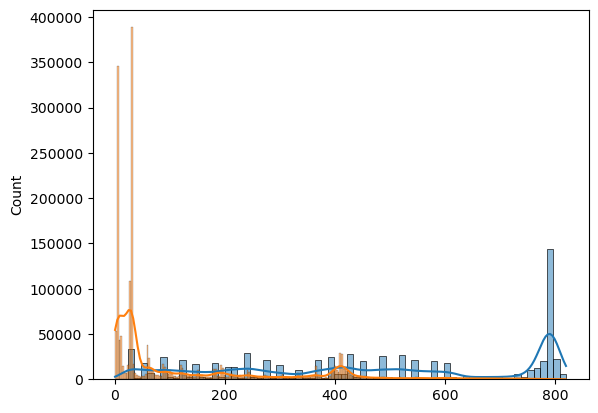

In [7]:
import warnings
import seaborn as sns

mask = np.where(y["event"] == 0)
ax = sns.histplot(y[mask]["duration"], kde=True);

mask = np.where(y["event"] == 1)
sns.histplot(y[mask]["duration"], ax=ax, kde=True);

## Kaplan Meier

In [8]:
from models.kaplan_meier import KaplanMeier
from model_selection.cross_validation import run_cv

km = KaplanMeier()
run_cv(X, y, km)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.2093 ± 0.0003
c_index: 0.5000 ± 0.0000
training_duration: 1.3081 ± 0.1224
prediction_duration: 0.6485 ± 0.0285


## Our YASGBT

In [9]:
from models.yasgbt import YASGBTClassifier
from model_selection.cross_validation import run_cv

yasgbt = YASGBTClassifier(
    sampling_strategy="uniform",
    n_iter=50,
    show_progressbar=False,
)
run_cv(X, y, yasgbt)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.1052 ± 0.0004
c_index: 0.8282 ± 0.0031
training_duration: 223.0191 ± 11.3942
prediction_duration: 46.0371 ± 1.2689


In [10]:
from models.yasgbt import YASGBTRegressor
from model_selection.cross_validation import run_cv

yasgbt = YASGBTRegressor(
    sampling_strategy="uniform",
    n_iter=50,
    show_progressbar=False,
)
run_cv(X, y, yasgbt)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.1030 ± 0.0002
c_index: 0.8111 ± 0.0015
training_duration: 176.9194 ± 1.9127
prediction_duration: 44.0239 ± 0.5316


In [15]:
import dill

from models.yasgbt import YASGBTClassifier
from model_selection.cross_validation import run_cv

yasgbt = YASGBTClassifier(
    sampling_strategy="uniform",
    n_iter=50,
    show_progressbar=False,
)
yasgbt.name = "YASGBT-useless"
X_useless = pd.DataFrame({"useless_col": np.ones(X.shape[0])})
run_cv(
    X_useless,
    y,
    yasgbt,
    single_fold=True,
    subsample_train=.1,
    subsample_val=.1,
)
dill.dump(yasgbt, open(f"{yasgbt.name}.pkl", "wb+"))

train set: 211739, val set: 52931
--------
ibs: 0.2085 ± 0.0000
c_index: 0.5000 ± 0.0000
training_duration: 16.8066 ± 0.0000
prediction_duration: 2.3533 ± 0.0000


Save YASGBT-useless for later purposes

## Scikit-Survival RandomSurvivalForest

In [16]:
from sksurv.ensemble import RandomSurvivalForest

from model_selection.cross_validation import run_cv
from model_selection.wrappers import SkurvWrapper

rf_params = dict(
    max_leaf_nodes=100,
    min_samples_leaf=100,
    n_estimators=30,
    max_features=8,
    n_jobs=4,
)
rf = RandomSurvivalForest(**rf_params)
rf = SkurvWrapper(rf)

run_cv(X, y, rf, subsample_train=0.05, subsample_val=0.05)

train set: 105869, val set: 26464
train set: 105869, val set: 26466
train set: 105869, val set: 26467
train set: 105869, val set: 26467
train set: 105869, val set: 26463
--------
ibs: 0.1076 ± 0.0010
c_index: 0.8150 ± 0.0010
training_duration: 310.6139 ± 14.3551
prediction_duration: 3.3171 ± 0.2553


## Scikit-Survival GradientBoostingSurvivalAnalysis

In [17]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from model_selection.cross_validation import run_cv
from model_selection.wrappers import SkurvWrapper

boosting_params = dict(
    max_leaf_nodes=100,
    min_samples_leaf=100,
    n_estimators=30,
    max_features=8,
)
gbsa = GradientBoostingSurvivalAnalysis(**boosting_params)
gbsa = SkurvWrapper(gbsa)

run_cv(X, y, gbsa, subsample_train=0.01, subsample_val=0.05)

train set: 21173, val set: 26464
train set: 21173, val set: 26466
train set: 21173, val set: 26467
train set: 21173, val set: 26467
train set: 21173, val set: 26463
--------
ibs: 0.1308 ± 0.0013
c_index: 0.8525 ± 0.0013
training_duration: 190.7718 ± 5.8192
prediction_duration: 1.5754 ± 0.2814


## XGBSE DebiasedBCE

In [18]:
from xgbse import XGBSEDebiasedBCE

from model_selection.cross_validation import run_cv
from model_selection.wrappers import XGBSEWrapper

PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}
xgbse_bce_cox = XGBSEDebiasedBCE(PARAMS_TREE_COX, n_jobs=4)

fit_kwargs=dict(
    num_boost_round=30,  # instead of 1000
    verbose_eval=5,  # print eval every 5 rounds
)

xgbse_bce_cox = XGBSEWrapper(xgbse_bce_cox, fit_kwargs=fit_kwargs)

run_cv(X, y, xgbse_bce_cox)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.1063 ± 0.0001
c_index: 0.8358 ± 0.0010
training_duration: 136.0189 ± 2.7377
prediction_duration: 8.2639 ± 0.9097


Note: `n_jobs=4` but all virtual cores (8) are running at maximum capacity during training.

## XGBSE KaplanTree

In [19]:
from xgbse import XGBSEKaplanTree

from model_selection.cross_validation import run_cv
from model_selection.wrappers import XGBSEWrapper

PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}
xgbse_kaplan_tree = XGBSEKaplanTree(PARAMS_TREE_COX)

fit_kwargs = {"persist_train": False} # don't build a BallTree and don't keep index
xgbse_kaplan_tree = XGBSEWrapper(xgbse_kaplan_tree, fit_kwargs=fit_kwargs)

run_cv(X, y, xgbse_kaplan_tree)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.1078 ± 0.0001
c_index: 0.8116 ± 0.0019
training_duration: 238.6778 ± 6.2294
prediction_duration: 1.4860 ± 0.0741


## Our BiasedForestGridBC

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from models.tree_transformer import TreeTransformer
from models.meta_grid_bc import MetaGridBC
from model_selection.cross_validation import run_cv
from model_selection.wrappers import PipelineWrapper

rf_params = dict(
    min_samples_leaf=100,
    max_leaf_nodes=100,
    n_estimators=30,
    max_features=8,
    n_jobs=4,
    verbose=False,
)
tree_transformer = TreeTransformer(
    # ignores censoring so it introduces some bias
    # at the cost of speed increase
    RandomForestRegressor(**rf_params)
)

lr_params = dict(C=1e-3, max_iter=500)
meta_grid_bc = MetaGridBC(
    LogisticRegression(**lr_params),
    verbose=False,
    n_jobs=4
)

forest_grid_bc = make_pipeline(
    tree_transformer,
    meta_grid_bc,
)

forest_grid_bc = PipelineWrapper(
    forest_grid_bc,
    name="BiasedForestGridBC"
)

run_cv(X, y, forest_grid_bc)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.1056 ± 0.0001
c_index: 0.8362 ± 0.0016
training_duration: 135.5663 ± 13.2908
prediction_duration: 7.8108 ± 0.3730


## Our BiasedKaplanTree

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

from models.kaplan_tree import KaplanTree
from models.tree_transformer import TreeTransformer
from model_selection.cross_validation import run_cv
from model_selection.wrappers import PipelineWrapper

tree_params = dict(
    min_samples_leaf=100,
    max_leaf_nodes=100,
)

biased_kaplan_tree = make_pipeline(
    TreeTransformer(
        DecisionTreeRegressor(**tree_params),
    ),
    KaplanTree(),
)

biased_kaplan_tree = PipelineWrapper(
    biased_kaplan_tree,
    name="BiasedKaplanTree",
)

run_cv(X, y, biased_kaplan_tree)

train set: 2117396, val set: 529325
train set: 2117397, val set: 529324
train set: 2117397, val set: 529325
train set: 2117397, val set: 529314
train set: 2117397, val set: 529318
--------
ibs: 0.1073 ± 0.0001
c_index: 0.8175 ± 0.0013
training_duration: 18.9460 ± 0.4347
prediction_duration: 3.2789 ± 0.0459


## PyCox DeepHitSingle

Single = No competing risks.

We run a simple train / test instead of CV because DeepHit is so slow.

In [22]:
import torchtuples as tt
from torch import optim

from pycox.models.deephit import DeepHitSingle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

from model_selection.wrappers import DeepHitWrapper
from model_selection.cross_validation import run_cv

num_durations = 100  # PyCox default is 10

# `label_transform` is used to bin duration into `num_durations` chunks.
# Bins can be inspected via `labtrans.cuts`.
# 
# We `fit_transform` the whole `y` instead of `fit_transform` on `y_train`
# then `transform` on `y_val` because there is no actual learning during the `fit`
# and therefore no risk of leakage.
#
# `y_pycox` is the tuple (idx_duration, event)
labtrans = DeepHitSingle.label_transform(num_durations)
y_ = labtrans.fit_transform(y["duration"], y["event"])

y_pycox = np.empty(
    dtype=[("event", bool), ("duration", np.float64)],
    shape=X.shape[0],
)
y_pycox["duration"] = y_[0]
y_pycox["event"] = y_[1]

# PyCox require covariates to be 32bits
X_pycox = X.copy().astype(np.float32)

# We also define the underlying net of the DeepHit model.
net = tt.practical.MLPVanilla(
    in_features=X.shape[1],
    num_nodes=[32, 32],
    out_features=num_durations,
    batch_norm=True,
    dropout=0.1,
)

deephit_single = DeepHitSingle(
    net,
    optim.Adam,
    alpha=0.2,
    sigma=0.1,
    duration_index=labtrans.cuts
)
deephit_single.optimizer.set_lr(0.01) # PyCox default

# PyCox uses `StandardScaler` on specific columns, we mimic it by normalizing
# on large numeric columns.
num_cols = [
    "days_between_subs",
    "days_since_reg_init",
    "payment_plan_days",
    "plan_list_price",
    "actual_amount_paid",
    "age_at_start",
]
idx_cols = [
    idx for idx, col in enumerate(X.columns) if col in num_cols
]

preprocessing = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), idx_cols)],
    remainder="passthrough",
)

deephit = make_pipeline(
    preprocessing,
    deephit_single,
)

fit_kwargs = dict(
    deephitsingle__batch_size=256,
    deephitsingle__epochs=10,
)

deephit = DeepHitWrapper(deephit, name="DeepHitSingle", fit_kwargs=fit_kwargs)
run_cv(X_pycox, y_pycox, deephit, single_fold=True)

train set: 2117396, val set: 529319
0:	[34s / 34s],		train_loss: 0.5573
1:	[33s / 1m:8s],		train_loss: 0.5425
2:	[34s / 1m:42s],		train_loss: 0.5400
3:	[34s / 2m:16s],		train_loss: 0.5390
4:	[34s / 2m:50s],		train_loss: 0.5386
5:	[34s / 3m:25s],		train_loss: 0.5379
6:	[34s / 4m:0s],		train_loss: 0.5371
7:	[35s / 4m:35s],		train_loss: 0.5357
8:	[33s / 5m:8s],		train_loss: 0.5353
9:	[35s / 5m:44s],		train_loss: 0.5350
--------
ibs: 0.1584 ± 0.0000
c_index: 0.7815 ± 0.0000
training_duration: 345.3055 ± 0.0000
prediction_duration: 0.7525 ± 0.0000


In [68]:
from model_selection.cross_validation import load_scores, save_scores

scores = load_scores("DeepHitSingle")
scores["times"] = [labtrans.cuts]  # replace pycox encoded times with our times
save_scores("DeepHitSingle", scores)

# Results

In [69]:
from model_selection.cross_validation import get_all_results

df_tables, df_lines = get_all_results()

In [70]:
df_tables

,Method,C_td,IBS,training_duration,prediction_duration,n_sample_train,n_sample_val
0,YASGBTRegressor,0.8111 ± 0.0015,0.1030 ± 0.0002,176.9194s,44.0239s,2117397,529349
1,YASGBTClassifier,0.8282 ± 0.0031,0.1052 ± 0.0004,223.0191s,46.0371s,2117397,529349
2,BiasedForestGridBC,0.8362 ± 0.0016,0.1056 ± 0.0001,135.5663s,7.8108s,2117397,529349
3,XGBSEDebiasedBCE,0.8358 ± 0.0010,0.1063 ± 0.0001,136.0189s,8.2639s,2117397,529349
4,BiasedKaplanTree,0.8175 ± 0.0013,0.1073 ± 0.0001,18.9460s,3.2789s,2117397,529349
5,RandomSurvivalForest,0.8150 ± 0.0010,0.1076 ± 0.0010,310.6139s,3.3171s,105869,26467
6,XGBSEKaplanTree,0.8116 ± 0.0019,0.1078 ± 0.0001,238.6778s,1.4860s,2117397,529349
7,GradientBoostingSurvivalAnalysis,0.8525 ± 0.0013,0.1308 ± 0.0013,190.7718s,1.5754s,21173,26467
8,DeepHitSingle,0.7815 ± 0.0000,0.1584 ± 0.0000,345.3055s,0.7525s,2117396,529350
9,YASGBT-useless,0.5000 ± 0.0000,0.2085 ± 0.0000,16.8066s,2.3533s,211739,52935


Methods from the [PyCox paper](https://jmlr.org/papers/volume20/18-424/18-424.pdf) obtained the following results with the same preprocessing:

<img src="../data/kkbox_v1/pycox_paper_table7.png" alt="pycox-table7" style="width: 400px;"/>

Our DeepHit benchmark yields a poorer C-index than reported by PyCox. The IBS is close, however.

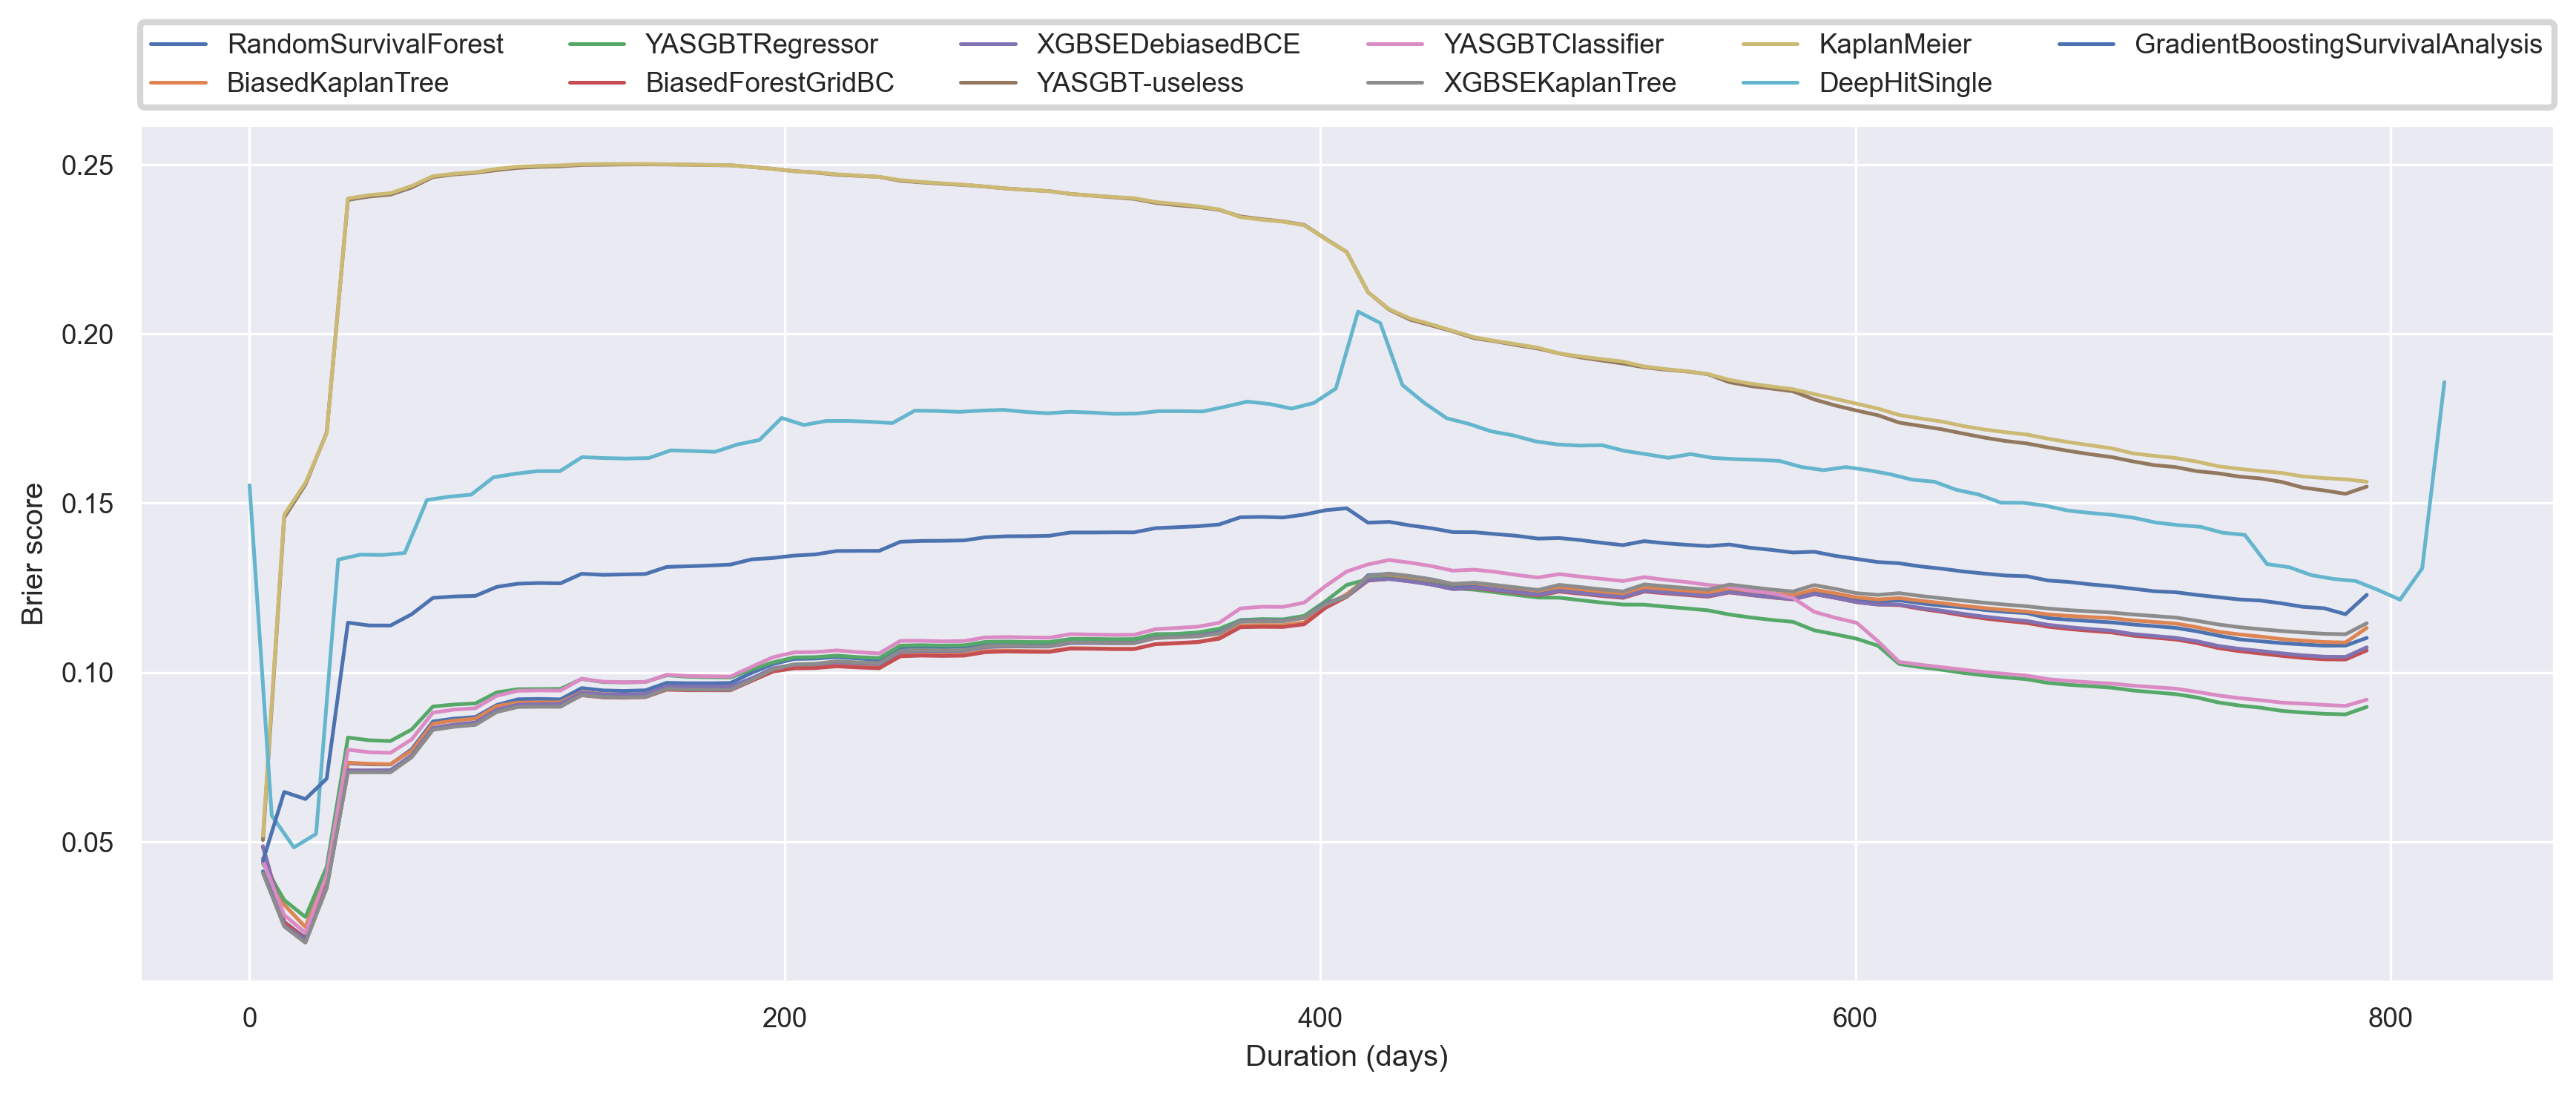

In [71]:
from plot.brier_score import plot_brier_scores

plot_brier_scores(df_lines)

Brier scores from the [PyCox paper](https://jmlr.org/papers/volume20/18-424/18-424.pdf) obtained the following results with the same preprocessing:

<img src="../data/kkbox_v1/pycox_paper_figure4.png" alt="pycox-table7" style="width: 900px;"/>

### Individual predictions

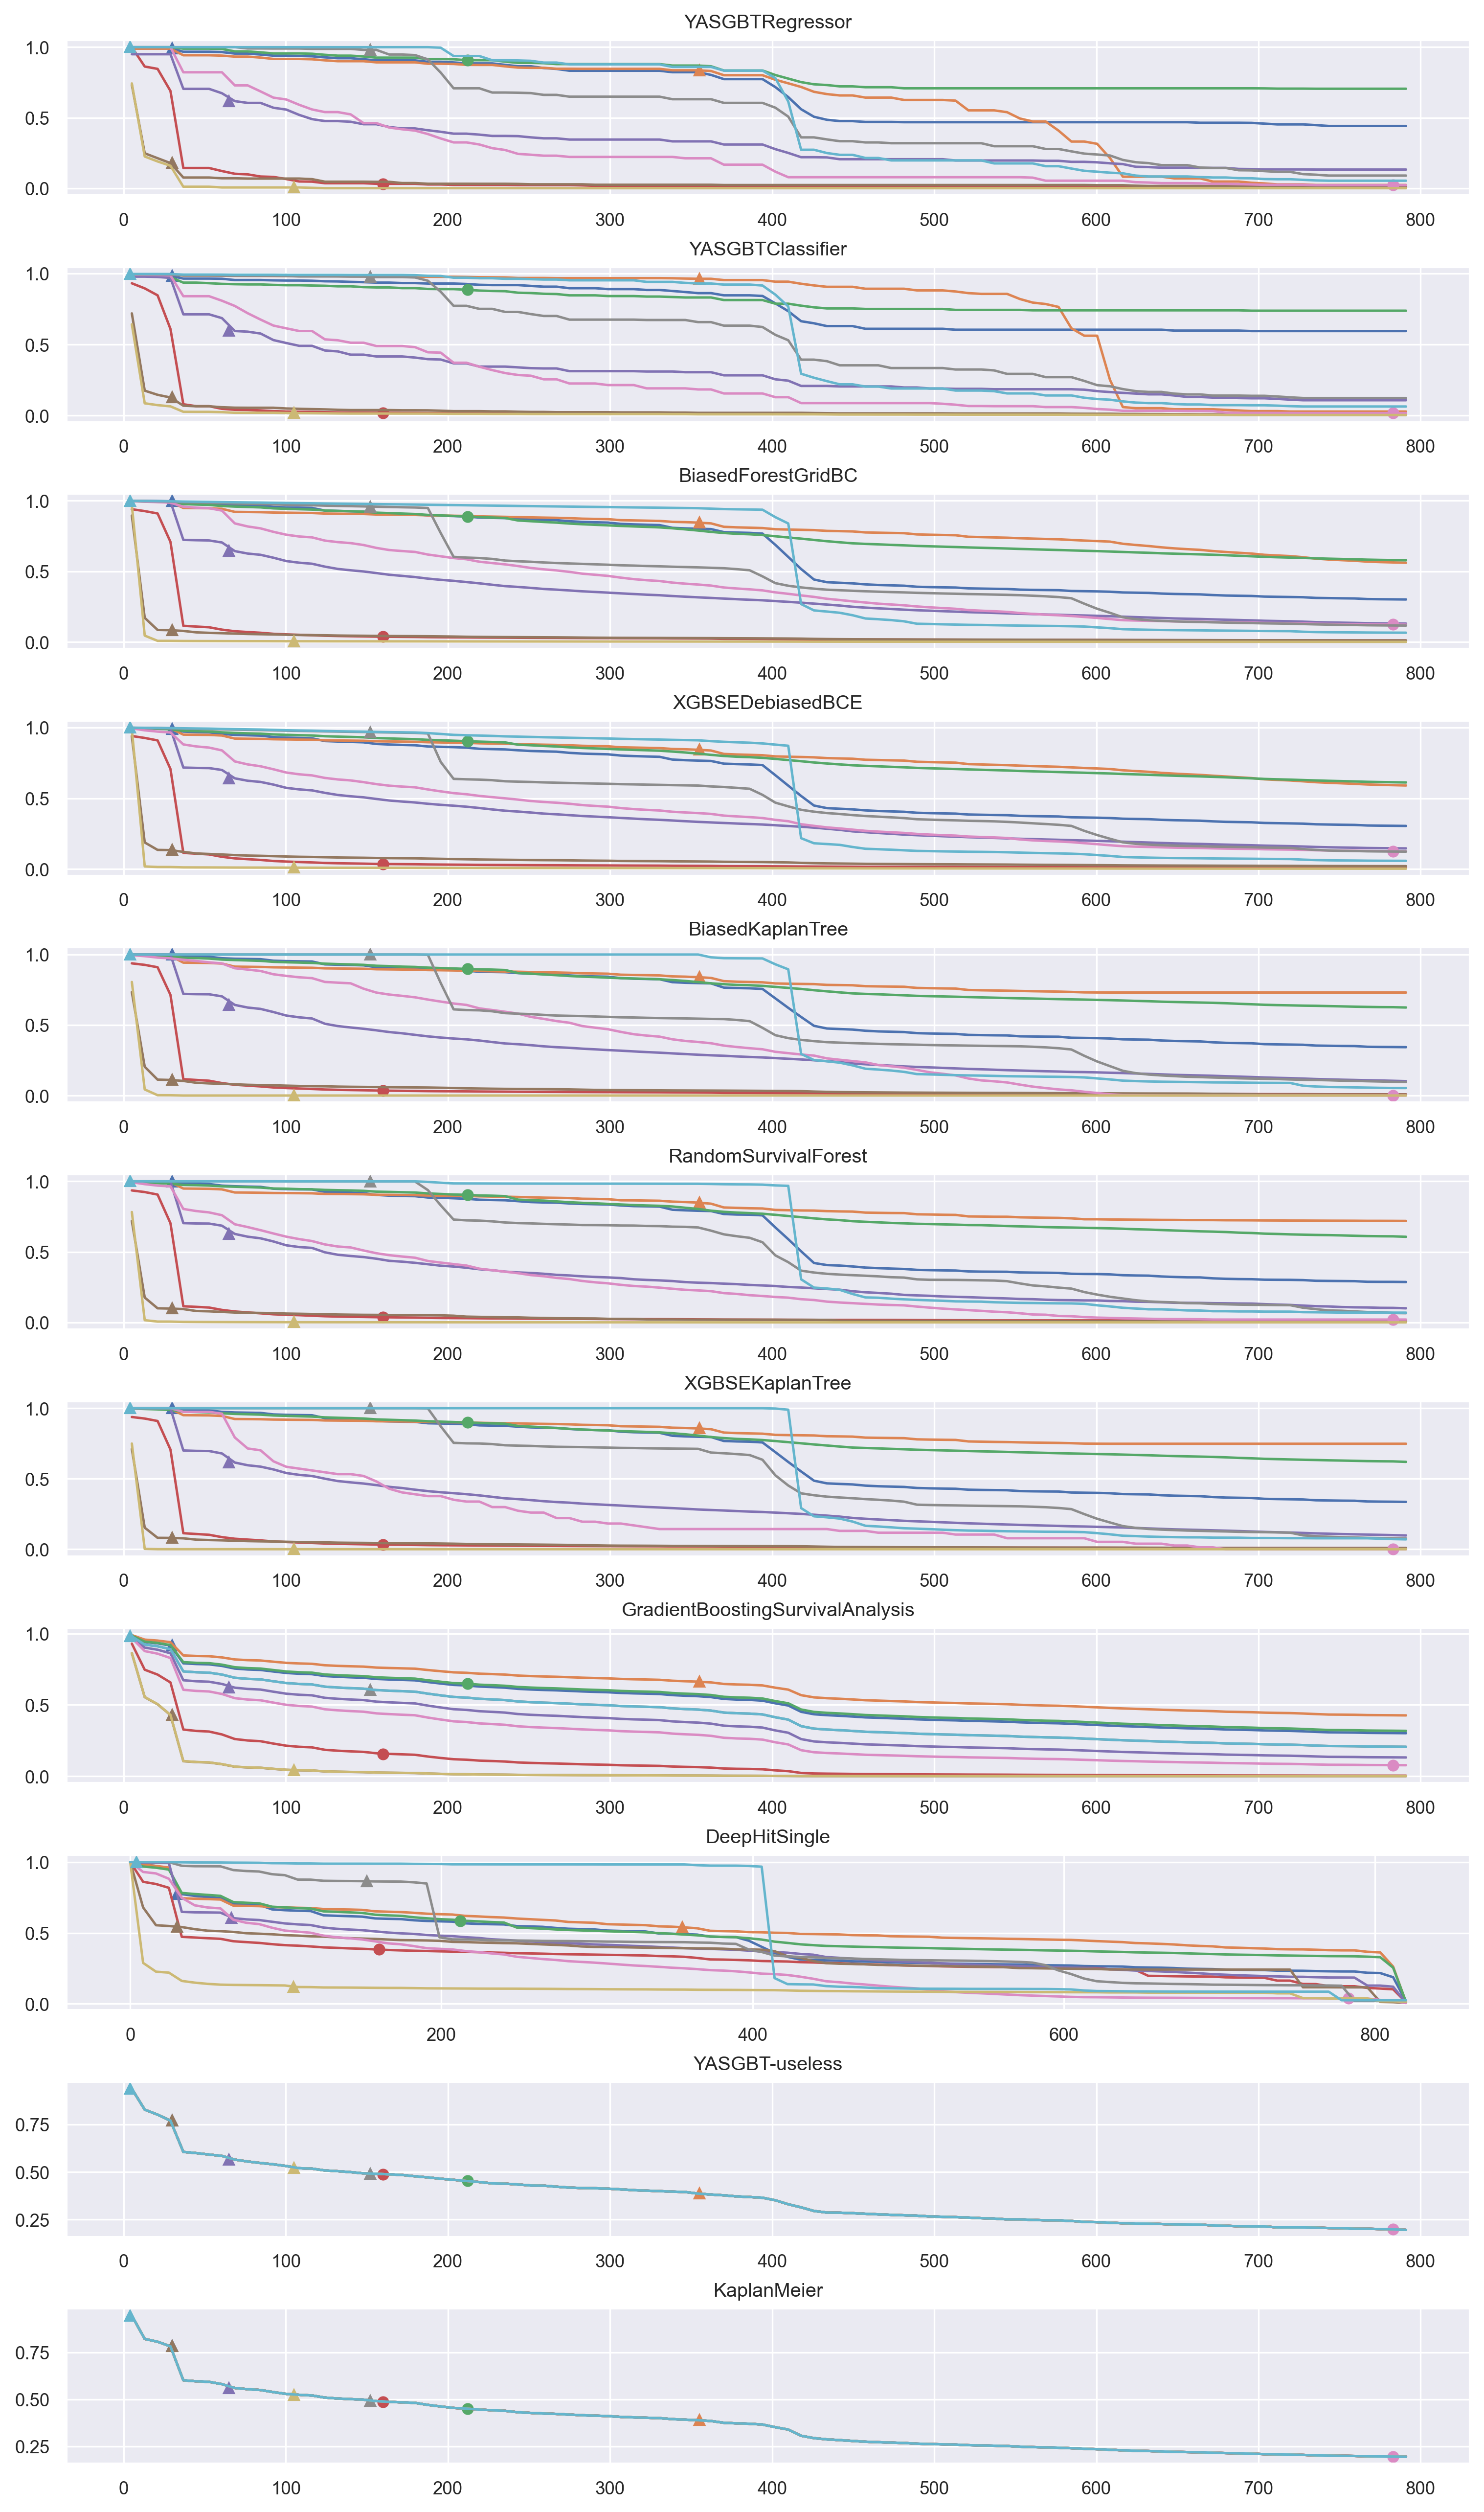

In [72]:
from plot.individuals import plot_individuals_survival_curve

# "^" is an event, "o" is a survivor 
plot_individuals_survival_curve(df_tables, df_lines, y, n_indiv=10)

## Extras

### Compare predictions with non-informative feature to Kaplan Meier

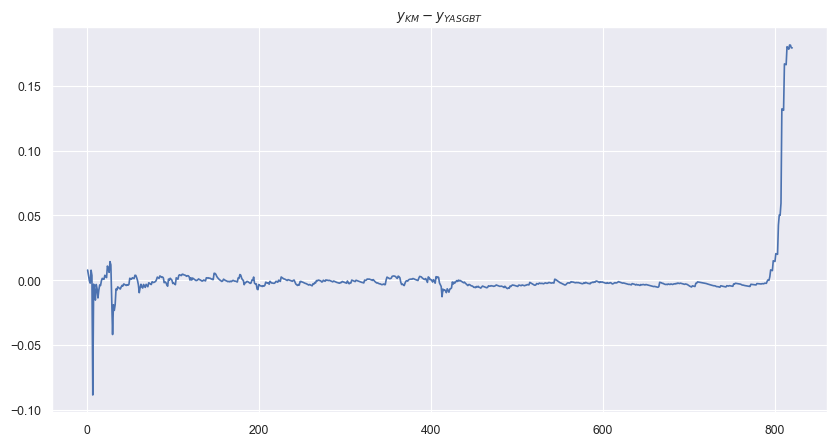

In [28]:
import dill
from matplotlib import pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

km_x, km_y = kaplan_meier_estimator(y["event"], y["duration"])

yasgbt_useless = dill.load(open("YASGBT-useless.pkl", "rb"))
yasgbt_y = yasgbt_useless.predict_survival_function(np.array([[1]]), times=km_x).ravel()

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(km_x, km_y - yasgbt_y)
plt.title("$y_{KM} - y_{YASGBT}$");